### Introduction

PINNs are a class of neural networks for solving partial differential equations. They are trained to minimize the residual of the differential equation, and the boundary and initial conditions. This is done by defining a loss function that is the sum of the mean squared error of the differential equation and the boundary and initial conditions. The loss function is minimized using gradient descent.


Reference: https://www.youtube.com/watch?v=LQ33-GeD-4Y

Let us assume our true function is:

$$u(x) = e^{ax} + x$$

We have:

$$\frac{du}{dx} = ae^{ax} + 1$$

$$\frac{d^2u}{dx^2} = a^2e^{ax}$$

We can create a differential equation from this:

$$\frac{d^2u}{dx^2} - a\frac{du}{dx} = a$$

We can also create a boundary condition from this:

$$u(0) = 1$$
$$u(1) = e^a + 1$$


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
x_lin = torch.linspace(0, 1, 100)
a = 2
u_true = torch.e**(a*x_lin) +   x_lin

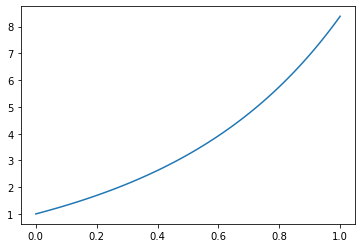

In [38]:
plt.plot(x_lin, u_true)

In [80]:
class MLP(nn.Module):
    def __init__(self, n_input=1, n_hidden=5, n_output=1):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(n_input, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_hidden)
        self.fc3 = nn.Linear(n_hidden, n_output)
        
    def forward(self, x):
        x = torch.sin(self.fc1(x))
        x = torch.sin(self.fc2(x))
        x = self.fc3(x)
        return x

In [81]:
u_model = MLP()
u_model

MLP(
  (fc1): Linear(in_features=1, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=5, bias=True)
  (fc3): Linear(in_features=5, out_features=1, bias=True)
)

In [82]:
# Let us compute du/dx for any x vector

x_vec = torch.randn(10, 1, requires_grad=True)
u_vec = u_model(x_vec)
print(u_vec)

tensor([[0.3282],
        [0.3020],
        [0.3418],
        [0.3326],
        [0.3218],
        [0.3455],
        [0.3245],
        [0.2926],
        [0.3455],
        [0.3388]], grad_fn=<AddmmBackward0>)


In [83]:
du_dx  = torch.autograd.grad(u_vec, # Whose gradient we want
                            x_vec, # WRT what we want the gradient
                            torch.ones_like(u_vec), # Shape of the gradient
                            create_graph=True)[0] # We want to differentiate again

In [84]:
du_dx

tensor([[ 0.0310],
        [ 0.0262],
        [-0.0229],
        [ 0.0299],
        [ 0.0313],
        [ 0.0191],
        [ 0.0314],
        [-0.0346],
        [ 0.0192],
        [ 0.0265]], grad_fn=<MmBackward0>)

In [85]:
# Now, let us compute d2u/dx2 for any x vector

x_vec = torch.randn(10, 1, requires_grad=True)
u_vec = u_model(x_vec)
du_dx  = torch.autograd.grad(u_vec, # Whose gradient we want
                            x_vec, # WRT what we want the gradient
                            torch.ones_like(u_vec), # Shape of the gradient
                            create_graph=True)[0] # We want to differentiate again

d2u_dx2  = torch.autograd.grad(du_dx, # Whose gradient we want
                            x_vec, # WRT what we want the gradient
                            torch.ones_like(du_dx), # Shape of the gradient
                            create_graph=True)[0] # We want to differentiate again


In [86]:
d2u_dx2

tensor([[-0.0196],
        [ 0.0052],
        [-0.0022],
        [-0.0376],
        [ 0.0092],
        [-0.0271],
        [-0.0228],
        [-0.0372],
        [-0.0282],
        [-0.0333]], grad_fn=<MmBackward0>)

In [87]:
# PDE loss

def pde_loss(model, x):
    u = model(x)
    du_dx = torch.autograd.grad(u, # Whose gradient we want
                            x, # WRT what we want the gradient
                            torch.ones_like(u), # Shape of the gradient
                            create_graph=True)[0] # We want to differentiate again
    d2u_dx2 = torch.autograd.grad(du_dx, # Whose gradient we want
                            x, # WRT what we want the gradient
                            torch.ones_like(du_dx), # Shape of the gradient
                            create_graph=True)[0] # We want to differentiate again
    
    # Our PDE is d2u/dx2 -a*du/dx = a
    # Loss = (d2u/dx2 -a*du/dx - a)**2
    loss = (d2u_dx2 - a*du_dx - a)**2
    return loss.mean()
    

In [88]:
# Boundary loss
def boundary_loss(model):
    # Boundary condition u(0) = 1
    x = torch.tensor([[0.0]])
    u = model(x)
    loss = (u - 1)**2
    
    # Boundary condition u(1) = e^a + 1
    x = torch.tensor([[1.0]])
    u = model(x)
    loss += (u - torch.e**(a) - 1)**2
    return loss.mean()

In [89]:
# Training loop
u_model = MLP()

optimizer = torch.optim.Adam(u_model.parameters(), lr=0.001)

for epoch in range(5000):
    optimizer.zero_grad()
    x_vec = torch.rand((200, 1), requires_grad=True)
    loss = pde_loss(u_model, x_vec) + boundary_loss(u_model)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print("Epoch: {}, Loss: {:.4f}".format(epoch, loss.item()))


    

Epoch: 0, Loss: 67.9660
Epoch: 10, Loss: 66.6901
Epoch: 20, Loss: 65.2943
Epoch: 30, Loss: 63.9695
Epoch: 40, Loss: 62.6850
Epoch: 50, Loss: 61.2587
Epoch: 60, Loss: 60.0264
Epoch: 70, Loss: 58.6717
Epoch: 80, Loss: 57.3171
Epoch: 90, Loss: 55.9113
Epoch: 100, Loss: 54.6272
Epoch: 110, Loss: 53.3323
Epoch: 120, Loss: 52.0833
Epoch: 130, Loss: 50.8265
Epoch: 140, Loss: 49.5321
Epoch: 150, Loss: 48.3675
Epoch: 160, Loss: 47.2812
Epoch: 170, Loss: 46.2676
Epoch: 180, Loss: 45.1809
Epoch: 190, Loss: 44.1872
Epoch: 200, Loss: 43.3664
Epoch: 210, Loss: 42.4653
Epoch: 220, Loss: 41.6310
Epoch: 230, Loss: 40.9401
Epoch: 240, Loss: 40.2886
Epoch: 250, Loss: 39.6953
Epoch: 260, Loss: 39.1209
Epoch: 270, Loss: 38.5331
Epoch: 280, Loss: 38.0630
Epoch: 290, Loss: 37.5903
Epoch: 300, Loss: 37.1756
Epoch: 310, Loss: 36.7660
Epoch: 320, Loss: 36.4114
Epoch: 330, Loss: 36.0545
Epoch: 340, Loss: 35.7171
Epoch: 350, Loss: 35.3948
Epoch: 360, Loss: 35.1014
Epoch: 370, Loss: 34.8141
Epoch: 380, Loss: 34.55

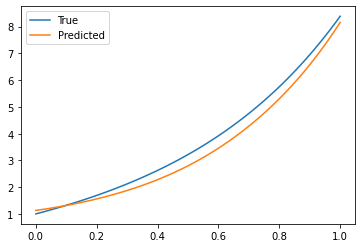

In [90]:
# Plotting the results
x_lin = torch.linspace(0, 1, 100)
u_true = torch.e**(a*x_lin) +   x_lin
u_pred = u_model(x_lin.unsqueeze(1)).detach()

plt.plot(x_lin, u_true, label="True")
plt.plot(x_lin, u_pred, label="Predicted")
plt.legend()